# **Notebook 18.2: 1D Diffusion Model**

This notebook investigates the diffusion encoder as described in section 18.3 and 18.4 of the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from scipy import stats
from IPython.display import display, clear_output

In [14]:
#Create pretty colormap as in book
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap_vals = np.vstack((r,g,b)).transpose()/255.0
my_colormap = ListedColormap(my_colormap_vals)

In [15]:
# Probability distribution for normal
def norm_pdf(x, mu, sigma):
    return np.exp(-0.5 * (x-mu) * (x-mu) / (sigma * sigma)) / np.sqrt(2*np.pi*sigma*sigma)

In [16]:
# True distribution is a mixture of four Gaussians
class TrueDataDistribution:
  # Constructor initializes parameters
  def __init__(self):
    self.mu = [1.5, -0.216, 0.45, -1.875]
    self.sigma = [0.3, 0.15, 0.525, 0.075]
    self.w = [0.2, 0.3, 0.35, 0.15]

  # Return PDF
  def pdf(self, x):
    return(self.w[0] *norm_pdf(x,self.mu[0],self.sigma[0]) +  self.w[1] *norm_pdf(x,self.mu[1],self.sigma[1]) + self.w[2] *norm_pdf(x,self.mu[2],self.sigma[2]) + self.w[3] *norm_pdf(x,self.mu[3],self.sigma[3]))

  # Draw samples
  def sample(self, n):
    hidden = np.random.choice(4, n, p=self.w)
    epsilon = np.random.normal(size=(n))
    mu_list = list(itemgetter(*hidden)(self.mu))
    sigma_list = list(itemgetter(*hidden)(self.sigma))
    return mu_list + sigma_list * epsilon

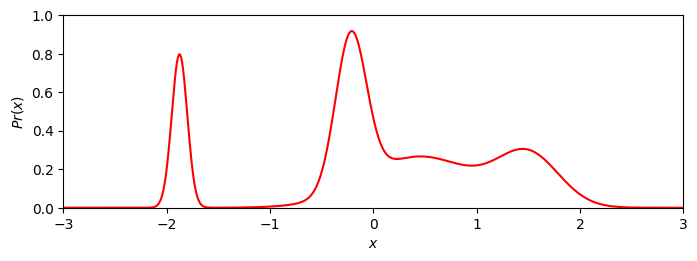

In [17]:
# Define ground truth probability distribution that we will model
true_dist = TrueDataDistribution()
# Let's visualize this
x_vals = np.arange(-3,3,0.01)
pr_x_true = true_dist.pdf(x_vals)
fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.plot(x_vals, pr_x_true, 'r-')
ax.set_xlabel("$x$")
ax.set_ylabel("$Pr(x)$")
ax.set_ylim(0,1.0)
ax.set_xlim(-3,3)
plt.show()

To train the model to describe this distribution, we'll need to generate pairs of samples drawn from $Pr(z_t|x)$ (diffusion kernel) and $q(z_{t-1}|z_{t},x)$ (equation 18.15).



In [18]:
# The diffusion kernel returns the parameters of Pr(z_{t}|x)
def diffusion_kernel(x, t, beta):
    alpha = np.power(1-beta,t)
    dk_mean = x * np.sqrt(alpha)
    dk_std = np.sqrt(1-alpha)
    return dk_mean, dk_std

# Compute mean and variance q(z_{t-1}|z_{t},x)
def conditional_diffusion_distribution(x,z_t,t,beta):
    # TODO -- Implement this function
    # Replace this line
    cd_mean = 0; cd_std = 1
    alpha_t = (1-beta)**t
    alpha_t_1 = (1-beta)**(t-1)

    A1 = ((1-alpha_t_1)/(1-alpha_t))*np.sqrt(1-beta)*z_t
    A2 = (np.sqrt(alpha_t_1)*beta/(1-alpha_t))*x

    B1 = beta*((1-alpha_t_1)/(1-alpha_t))

    cd_mean = A1+A2
    cd_std = B1

    return cd_mean, cd_std

def get_data_pairs(x_train,t,beta):
    # Find diffusion kernel for every x_train and draw samples
    dk_mean, dk_std = diffusion_kernel(x_train, t, beta)
    z_t = np.random.normal(size=x_train.shape) * dk_std + dk_mean
    # Find conditional diffusion distribution for each x_train, z pair and draw samples
    cd_mean, cd_std  = conditional_diffusion_distribution(x_train,z_t,t,beta)
    if t == 1:
      z_tminus1 = x_train
    else:
      z_tminus1 = np.random.normal(size=x_train.shape) * cd_std + cd_mean

    return z_t, z_tminus1

We also need models $\text{f}_t[z_{t},\phi_{t}]$ that map from $z_{t}$ to the mean of the distribution at time $z_{t-1}$.  We're just going to use a very hacky non-parametric model (basically a lookup table) that tells you the result based on the (quantized) input.

In [19]:
# This code is really ugly!  Don't look too closely at it!
# All you need to know is that it is a model that trains from pairs zt, zt_minus1
# And can then predict zt
class NonParametricModel():
   # Constructor initializes parameters
  def __init__(self):

    self.inc = 0.01
    self.max_val = 3.0
    self.model = []

  # Learns a model that predicts z_t_minus1 given z_t
  def train(self, zt, zt_minus1):
      zt = np.clip(zt,-self.max_val,self.max_val)
      zt_minus1 = np.clip(zt_minus1,-self.max_val,self.max_val)
      bins = np.arange(-self.max_val,self.max_val+self.inc,self.inc)
      numerator, *_ = stats.binned_statistic(zt, zt_minus1-zt, statistic='sum',bins=bins)
      denominator, *_ = stats.binned_statistic(zt, zt_minus1-zt, statistic='count',bins=bins)
      self.model = numerator / (denominator + 1)

  def predict(self, zt):
      bin_index = np.floor((zt+self.max_val)/self.inc)
      bin_index = np.clip(bin_index,0, len(self.model)-1).astype('uint32')
      return zt + self.model[bin_index]

In [20]:
# Sample data from distribution (this would usually be our collected training set)
n_sample = 100000
x_train = true_dist.sample(n_sample)

# Define model parameters
T = 100
beta = 0.01511

all_models = []
for t in range(0,T):
    clear_output(wait=True)
    display("Training timestep %d"%(t))
    zt,zt_minus1 = get_data_pairs(x_train,t+1,beta)
    all_models.append(NonParametricModel())
    # The model at index t maps data from z_{t+1} to z_{t}
    all_models[t].train(zt,zt_minus1)

'Training timestep 99'

Now that we've learned the model, let's draw some samples from it.  We start at $z_{100}$ and use the model to predict $z_{99}$, then $z_{98}$ and so on until finally we get to $z_{1}$ and then $x$ (represented as $z_{0}$ here). We'll store all of the intermediate stages as well, so we can plot the trajectories.  See equations 18.16.

In [28]:
def sample(model, T, sigma_t, n_samples):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((T+1,n_samples))

    # TODO -- Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    # Replace this line
    samples[T,:] = np.random.normal(size=(1,n_samples))

    # For t=100...99..98... ...0
    for t in range(T,0,-1):
        clear_output(wait=True)
        display("Predicting z_{%d} from z_{%d}"%(t-1,t))
        # TODO Predict samples[t-1,:] from samples[t,:] using the appropriate model
        # Replace this line:
        samples[t-1,:] = model[t-1].predict(samples[t,:])

        # If not the last time step
        if t>0:
            # TODO Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
            # Replace this line
            samples[t-1,:] = samples[t-1,:] + np.random.normal(0,sigma_t,size=(1,n_samples))

    return samples

Now let's run the diffusion process for a whole bunch of samples

'Predicting z_{0} from z_{1}'

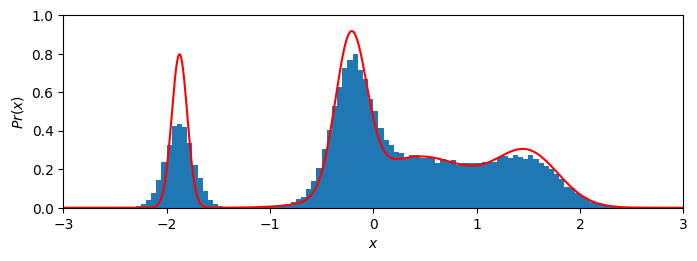

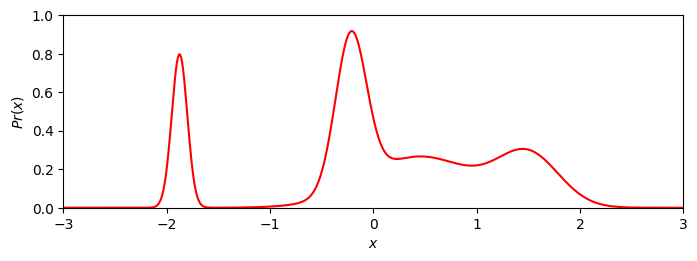

In [31]:
sigma_t=0.12288
n_samples = 100000
samples = sample(all_models, T, sigma_t, n_samples)

# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-3,3.05,0.05)

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
plt.hist(sampled_data, bins=bins, density =True)
ax.set_ylim(0, 1)
# mrege these two graphs into one
ax.plot(x_vals, pr_x_true, 'r-')
ax.set_xlabel("$x$")
ax.set_ylabel("$Pr(x)$")
plt.show()
# Define ground truth probability distribution that we will model
true_dist = TrueDataDistribution()
# Let's visualize this
x_vals = np.arange(-3,3,0.01)
pr_x_true = true_dist.pdf(x_vals)
fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.plot(x_vals, pr_x_true, 'r-')
ax.set_xlabel("$x$")
ax.set_ylabel("$Pr(x)$")
ax.set_ylim(0,1.0)
ax.set_xlim(-3,3)
plt.show()

Let's, plot the evolution of a few of the paths as in figure 18.7 (paths are from bottom to top now).

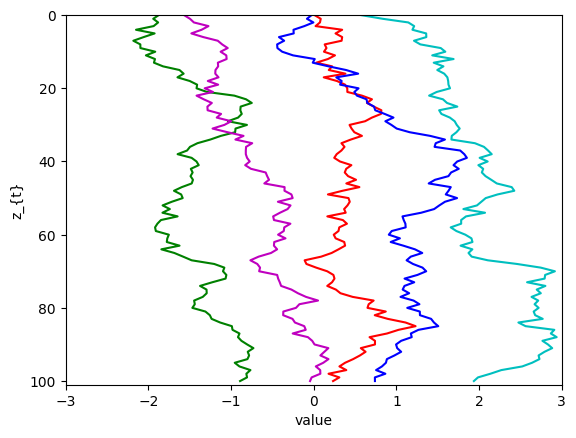

In [32]:
fig, ax = plt.subplots()
t_vals = np.arange(0,101,1)
ax.plot(samples[:,0],t_vals,'r-')
ax.plot(samples[:,1],t_vals,'g-')
ax.plot(samples[:,2],t_vals,'b-')
ax.plot(samples[:,3],t_vals,'c-')
ax.plot(samples[:,4],t_vals,'m-')
ax.set_xlim([-3,3])
ax.set_ylim([101, 0])
ax.set_xlabel('value')
ax.set_ylabel('z_{t}')
plt.show()

Notice that the samples have a tendency to move from positions that are near the center at time 100 to positions that are high in the true probability distribution at time 0